In [70]:
# Import dependencies for XGBoost
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# Load the data
data = pd.read_csv('Lagged VIX Data.csv',index_col="Date")
data.index = pd.to_datetime(data.index)
data_clean = data
data_clean.fillna(data_clean.mean(), inplace=True)

In [72]:
explanatory_vars = data_clean.drop(columns=['Next Month VIX'])
y_entire = data_clean['Next Month VIX']

In [73]:
# Split the data into training and testing sets first
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(explanatory_vars, y_entire, test_size=0.1, shuffle=False)

In [74]:
all_feature_names = list(X_train_full.columns)
# Initialize variables
best_features = []
best_rmse = float('inf')
remaining_features = all_feature_names.copy()

In [75]:
x_train, x_opt, y_train, y_opt = train_test_split(X_train_full, y_train_full, test_size=0.111, shuffle=False)

In [76]:
from sklearn.feature_selection import RFE

# Initialize the XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=3, random_state=42)

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(estimator=xg_reg, n_features_to_select=10, step=1)  # Select top 10 features

# Fit RFE on the training data
rfe.fit(x_train, y_train)

# Get the selected feature names
selected_features = x_train.columns[rfe.support_]

# Evaluate the model with the selected features
X_train_selected = rfe.transform(x_train)
X_test_selected = rfe.transform(x_opt)

# Retrain the model using only the selected features
xg_reg.fit(X_train_selected, y_train)
y_pred_selected = xg_reg.predict(X_test_selected)

# Calculate the new evaluation metrics
mse_selected = root_mean_squared_error(y_opt, y_pred_selected)
r2_selected = r2_score(y_opt, y_pred_selected)

selected_features, mse_selected, r2_selected


(Index(['Total Nonfarm Employees', 'NASDAQ High', 'NASDAQ Adj Close',
        'NIKKEI High', 'GOLD High', 'OIL High', 'OIL Volume', 'VIX',
        'DJI High Minus Low', 'NASDAQ High Minus Low'],
       dtype='object'),
 3.4618129953801313,
 0.42735234984951986)

In [77]:
X_train, X_opt, y_train, y_opt = train_test_split(X_train_full[selected_features], y_train_full, test_size=0.111111, shuffle=False)

In [78]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 7, None],          # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2, None],  # Step size shrinkage
    'subsample': [0.8, 1.0, None],         # Fraction of samples used for fitting
    'colsample_bytree': [0.8, 1.0, None]   # Fraction of features used per tree
}

# Initialize RandomForestRegressor and GridSearchCV
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract the best model and parameters
best_xg = grid_search.best_estimator_
optimized_params = grid_search.best_params_

# Make predictions and calculate performance metrics
y_pred = best_xg.predict(X_opt)
rmse = root_mean_squared_error(y_opt, y_pred)
mae = mean_absolute_error(y_opt, y_pred)
r2 = r2_score(y_opt, y_pred)

print("Optimized Parameters:", optimized_params)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Optimized Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
RMSE: 2.8485, MAE: 2.3952, R²: 0.6123


In [79]:
X = X_train_full[selected_features]
y = y_train_full

In [80]:
best_xg.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [81]:
y_pred = best_xg.predict(X_test_full[selected_features])
# Calculate RMSE
rmse = root_mean_squared_error(y_test_full, y_pred)
# Calculate MAPE
mape = np.mean(np.abs((y_test_full - y_pred) / y_test_full)) * 100
# Calculate R²
r2 = r2_score(y_test_full, y_pred)
# Calculate Directional Accuracy
directional_accuracy = np.mean(np.sign(y_test_full.diff().dropna()) == np.sign(pd.Series(y_pred, index=y_test_full.index).diff().dropna())) * 100

print(f"RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}%")

RMSE: 3.3207, MAPE: 21.1305%, R²: -1.9405, Directional Accuracy: 45.4545%


In [82]:
feature_importances = best_xg.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [83]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

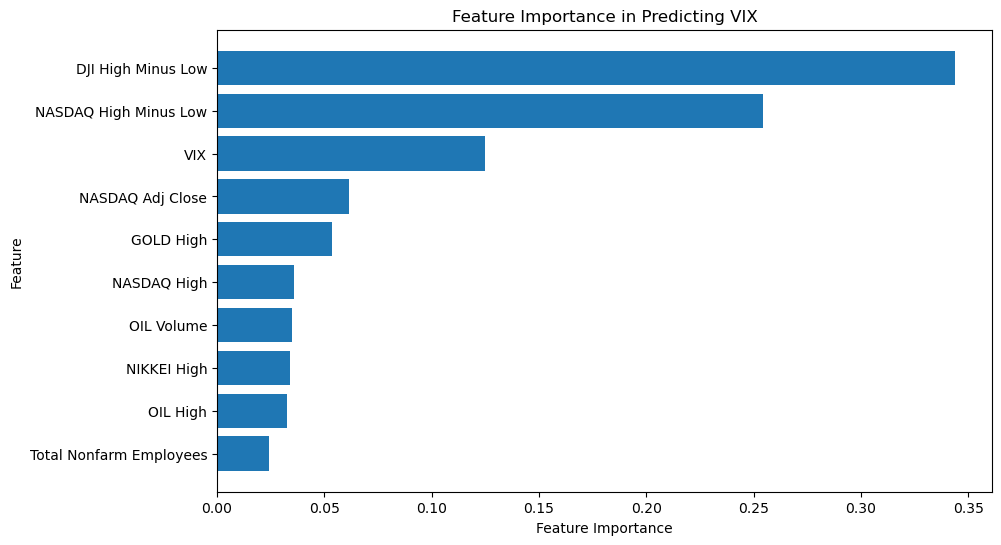

In [84]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting VIX')
plt.gca().invert_yaxis()
plt.show()

In [85]:
# Add dates back to predictions
y_pred_df = pd.DataFrame(y_pred, index=X_test_full.index, columns=['Next Month VIX Prediction'])
y_test_df = pd.DataFrame(y_test_full, index=X_test_full.index, columns=['Next Month VIX'])

In [86]:
y_pred_df

,Next Month VIX Prediction
Date,
2023-09-01,15.753530
2023-10-01,17.095179
2023-11-01,19.298117
2023-12-01,15.716556
2024-01-01,15.959120
2024-02-01,15.870399
2024-03-01,15.609182
2024-04-01,17.152651
2024-05-01,16.679705


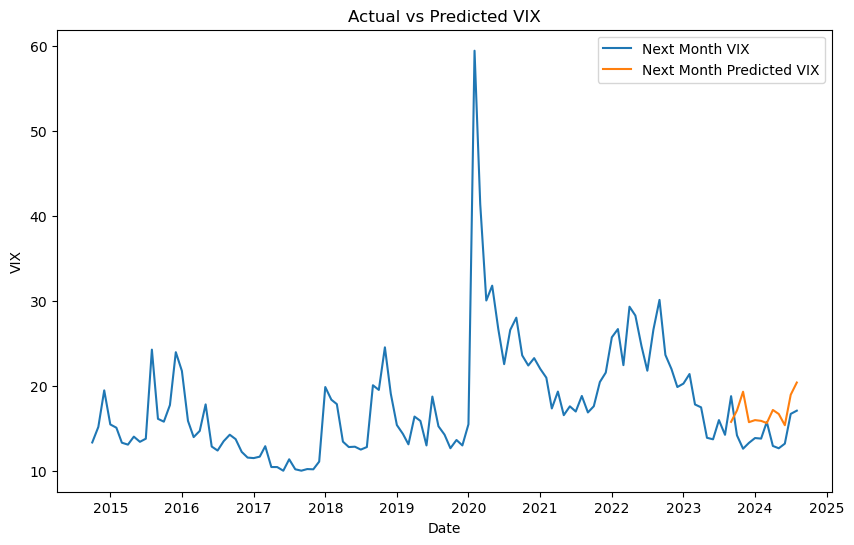

In [87]:
# Plot the actual VIX for the entire time series and the predicted VIX for the test set
plt.figure(figsize=(10, 6))
plt.title('Actual vs Predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.plot(y_entire, label='Next Month VIX')
plt.plot(y_pred_df.index, y_pred_df['Next Month VIX Prediction'], label='Next Month Predicted VIX')
plt.legend()
plt.show()



In [88]:
# Combine Data Frame of Predictions and Actual VIX
combined = pd.concat([y_test_df, y_pred_df], axis=1)
combined

,Next Month VIX,Next Month VIX Prediction
Date,,
2023-09-01,18.775,15.753530
2023-10-01,14.165,17.095179
2023-11-01,12.595,19.298117
2023-12-01,13.280,15.716556
2024-01-01,13.850,15.959120
2024-02-01,13.785,15.870399
2024-03-01,15.745,15.609182
2024-04-01,12.920,17.152651
2024-05-01,12.645,16.679705
